In [1]:
import pandas as pd
import numpy as np
movies = pd.read_csv("movie_genres.csv", sep=",", index_col=0)
users = pd.read_csv("user_reviews.csv", sep=",", index_col=0)
df = pd.read_csv("MovieRatingData.csv", sep=",")

In [27]:
movies['movieId'] = np.arange(len(movies))+1

In [13]:
df["rating"].replace(0,np.nan,inplace=True)

In [15]:
pivot_dataset = df.pivot(index='movieId',columns='userId',values='rating')
pivot_dataset.fillna(0,inplace=True)
pivot_dataset.head()

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,591.0,592.0,593.0,594.0,595.0,596.0,597.0,598.0,599.0,600.0
movieId,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
no_user_voted = df.groupby('movieId')['rating'].count()
no_movies_voted = df.groupby('userId')['rating'].count()
no_user_voted,no_movies_voted


(movieId
 1.0       14
 2.0       10
 3.0       11
 4.0       10
 5.0       11
           ..
 1996.0    10
 1997.0     6
 1998.0     3
 1999.0     9
 2000.0     8
 Name: rating, Length: 2000, dtype: int64,
 userId
 1.0      39
 2.0      30
 3.0      36
 4.0      32
 5.0      28
          ..
 596.0    31
 597.0    26
 598.0    28
 599.0    28
 600.0    23
 Name: rating, Length: 600, dtype: int64)

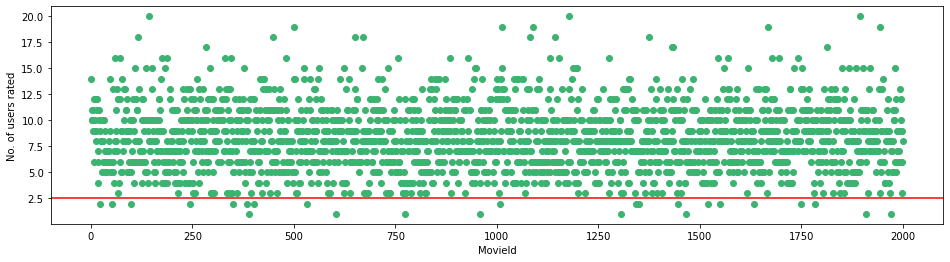

In [18]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=2.5,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users rated')
plt.show()

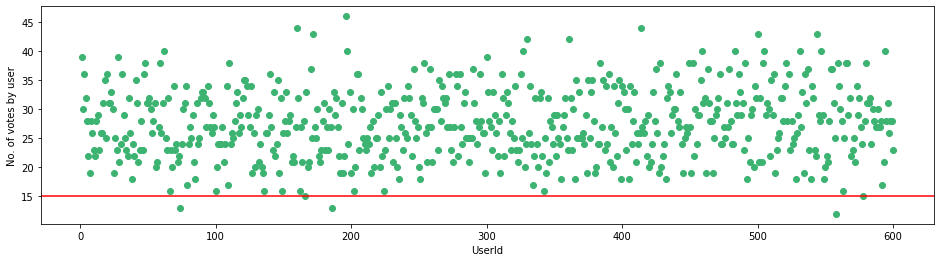

In [21]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=15,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

### Model that use KNN

Removing sparsity  
because we have many cell with zero

In [23]:
from scipy.sparse import csr_matrix
csr_data = csr_matrix(pivot_dataset.values)
pivot_dataset.reset_index(inplace=True)
csr_data

<2000x601 sparse matrix of type '<class 'numpy.float64'>'
	with 18525 stored elements in Compressed Sparse Row format>

In [24]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [41]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 1999
    movie_list = movies[movies['movie_title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = pivot_dataset[pivot_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = pivot_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'movie_title':movies.iloc[idx]['movie_title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

In [30]:
movie_list = movies[movies['movie_title'].str.contains('Furious 7')]  
movie_list

,movie_title,genre_action,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,genre_documentary,genre_drama,genre_family,...,genre_news,genre_reality-tv,genre_romance,genre_sci-fi,genre_short,genre_sport,genre_thriller,genre_war,genre_western,movieId
1666,Furious 7,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1667


In [37]:
a =csr_data[1667]
a

<1x601 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [42]:
get_movie_recommendation('Furious 7')

,movie_title,Distance
1,The Net,0.938020
2,Happily N'Ever After,0.837688
3,Tomorrowland,0.774516
4,American Hero,0.695016
5,Das Boot,0.664828
...,...,...
1995,Butterfly Girl,0.000045
1996,Ted 2,0.000045
1997,The Ballad of Gregorio Cortez,0.000045
1998,Pale Rider,0.000043
